# Test of clustering algorithms

## Basic setup

### Import the library with Ctypes

I wrote the algorithms in a C++ library, which can be called from Python using ctypes

In [88]:
# The following is used to close the library, so it can be loaded again after updating it
handle = lib._handle
del lib
_ctypes.dlclose(handle)

In [1]:
import _ctypes
import ctypes

# Load the library
# The methods below work for me
# lib = ctypes.cdll.LoadLibrary( os.getcwd() + "/../DSAlgorithms/build/libDSAlgorithms.so.1.0.1" )
lib = ctypes.cdll.LoadLibrary( "../DSAlgorithms/build/libDSAlgorithms.so" )

### Import other Python packages

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# Set the default size for the plots with matplotlib
matplotlib.rcParams[ "figure.figsize" ] = [ 10, 6 ]
matplotlib.rcParams[ "figure.dpi" ] = 100


## Generate several datasets

I follow the notebooks provided with https://arxiv.org/abs/1803.08823

In [30]:
from sklearn import datasets

# Number of points in each dataset
# n_points = 250
n_points = 1000
# Random state for the anisotropic data and the blobs with varied variances
random_state = 170

#=======================================================
# Generate the datasets
#=======================================================

noisy_circles = datasets.make_circles( n_samples=n_points, factor=0.5, noise=0.05 )
noisy_moons = datasets.make_moons( n_samples=n_points, noise=0.05 )
blobs = datasets.make_blobs( n_samples=n_points, random_state=8 )
no_structure = np.random.rand( n_points, 2 ), np.zeros( (n_points), dtype=int )
# Anisotropically distributed data
X, y = datasets.make_blobs( n_samples=n_points, random_state=random_state )
transformation = [ [0.6, -0.6], [-0.4, 0.8] ]
anisotropic = ( np.dot(X, transformation), y )
# Blobs with varied variances
varied_blobs = datasets.make_blobs( n_samples=n_points,
                                    cluster_std=[1.0, 2.5, 0.5],
                                    random_state=random_state )

# List with all the datasets
gen_datasets = [
                noisy_circles,
                noisy_moons,
                blobs,
                no_structure,
                anisotropic,
                varied_blobs
               ]
# True labels of all the datasets
gen_datasets_true_labels = [ dataset[1] for dataset in gen_datasets ]

# Parameters for clustering each dataset
gen_datasets_cluster_parameters = [ 
                                     { "n_clusters" : 2 },
                                     { "n_clusters" : 2 },
                                     { "n_clusters" : 3 },
                                     { "n_clusters" : 3 },
                                     { "n_clusters" : 3 },
                                     { "n_clusters" : 3 },
                                  ]

#=======================================================
# Function to plot all the datasets and their labels
#=======================================================

def plot_datasets_with_labels( datasets, labels, title=None ):
    fig = plt.figure( figsize=(15, 10) )
    if title:
        fig.suptitle( title, fontsize=14 )
    for index_dataset, dataset in enumerate(datasets):
        plt.subplot( 2, 3, index_dataset + 1 )
        for class_index in range(max(labels[index_dataset]) + 1):
            # mask = dataset[1] == class_index
            mask = labels[index_dataset] == class_index
            plt.scatter( dataset[0][mask, 0], dataset[0][mask,1] )
    plt.show()

# Plot the datasets with the true labels
# plot_datasets_with_labels( gen_datasets, gen_datasets_true_labels, "True labels" )

## K-means clustering

#### Wrappers for the functions written in C++

In [31]:
def Kmeans_clusters_in_Cpp( data, nClusters ):
    # Arrays for the output of the computation in C++
    # This will hold the cluster index of each data point
    clusterIndices = np.zeros( (len(data)), dtype=np.int32 )
    # This will hold the position of the cluster means
    clusterMeans = np.zeros( (nClusters, len(data[0])), dtype=float )

    # Make sure that both arrays are contiguous, and that their data type is correct
    if not data.flags["C_CONTIGUOUS"]:
        data = np.ascontiguousarray( data )
    if not clusterIndices.flags["C_CONTIGUOUS"]:
        clusterIndices = np.ascontiguousarray( clusterIndices )
    if not clusterMeans.flags["C_CONTIGUOUS"]:
        clusterMeans = np.ascontiguousarray( clusterMeans )
    if not data.dtype == 'float':
        data = data.astype( 'float' )

    # Setup the types of the arguments of the function
    lib.computeKMeansClusters.argtypes = [ np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ),
                                           ctypes.c_int, ctypes.c_int, ctypes.c_int,
                                           np.ctypeslib.ndpointer( dtype=ctypes.c_int, flags="C_CONTIGUOUS" ),
                                           np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ) ]

    # Setup the type of the return value of the function
    lib.computeKMeansClusters.restype = None

    # Call the function
    lib.computeKMeansClusters( data, len(data), len(data[0]), nClusters, clusterIndices, clusterMeans )

    return clusterIndices, clusterMeans

#### Apply it on the `test_cluster.dat` dataset

In [32]:
# Load the dataset
file = open('Datasets/test_cluster.dat')
data = []

for line in file:
    data.append( [] )
    line_aux = line.split( ' ' )
    for i in range( len(line_aux) ):
        data[-1].append( float(line_aux[i]) )
data = np.array( data )
file.close()

In [33]:
# Compute the positions and labels of the clusters
nClusters = 5
clusterIndices, clusterMeans = Kmeans_clusters_in_Cpp( data, 5 )

Data classified in 5 clusters, found after 8 iterations.


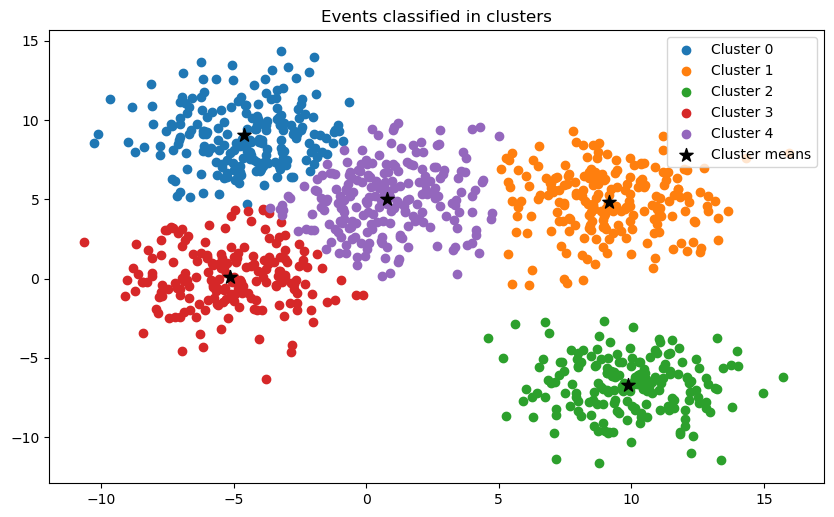

In [34]:
# Plot the data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title('Events classified in clusters')

# Plot the data with different colors for the clusters
for k in range( nClusters ):
    mask = clusterIndices == k
    ax1.scatter( data[mask, 0], data[mask, 1], label="Cluster {}".format(k))

# Plot also the centers of the clusters
ax1.scatter( clusterMeans[:, 0], clusterMeans[:, 1], c='k', s=100, marker='*', label="Cluster means" )

plt.legend(loc="best")

plt.show()

#### Apply it on several generated datasets

I follow the notebooks provided with https://arxiv.org/abs/1803.08823

In [35]:
# Array to store the cluster labels of each dataset
gen_datasets_pred_labels = np.zeros( (len(gen_datasets_true_labels), len(gen_datasets_true_labels[0])), dtype=int )

for i_dataset, dataset in enumerate(gen_datasets):
    # Compute the cluster labels
    clusterLabels, _ = Kmeans_clusters_in_Cpp( dataset[0], gen_datasets_cluster_parameters[i_dataset]["n_clusters"] )
    # Store the cluster labels
    gen_datasets_pred_labels[i_dataset] = clusterLabels


Data classified in 2 clusters, found after 9 iterations.
Data classified in 2 clusters, found after 9 iterations.
Data classified in 3 clusters, found after 3 iterations.
Data classified in 3 clusters, found after 18 iterations.
Data classified in 3 clusters, found after 7 iterations.
Data classified in 3 clusters, found after 10 iterations.


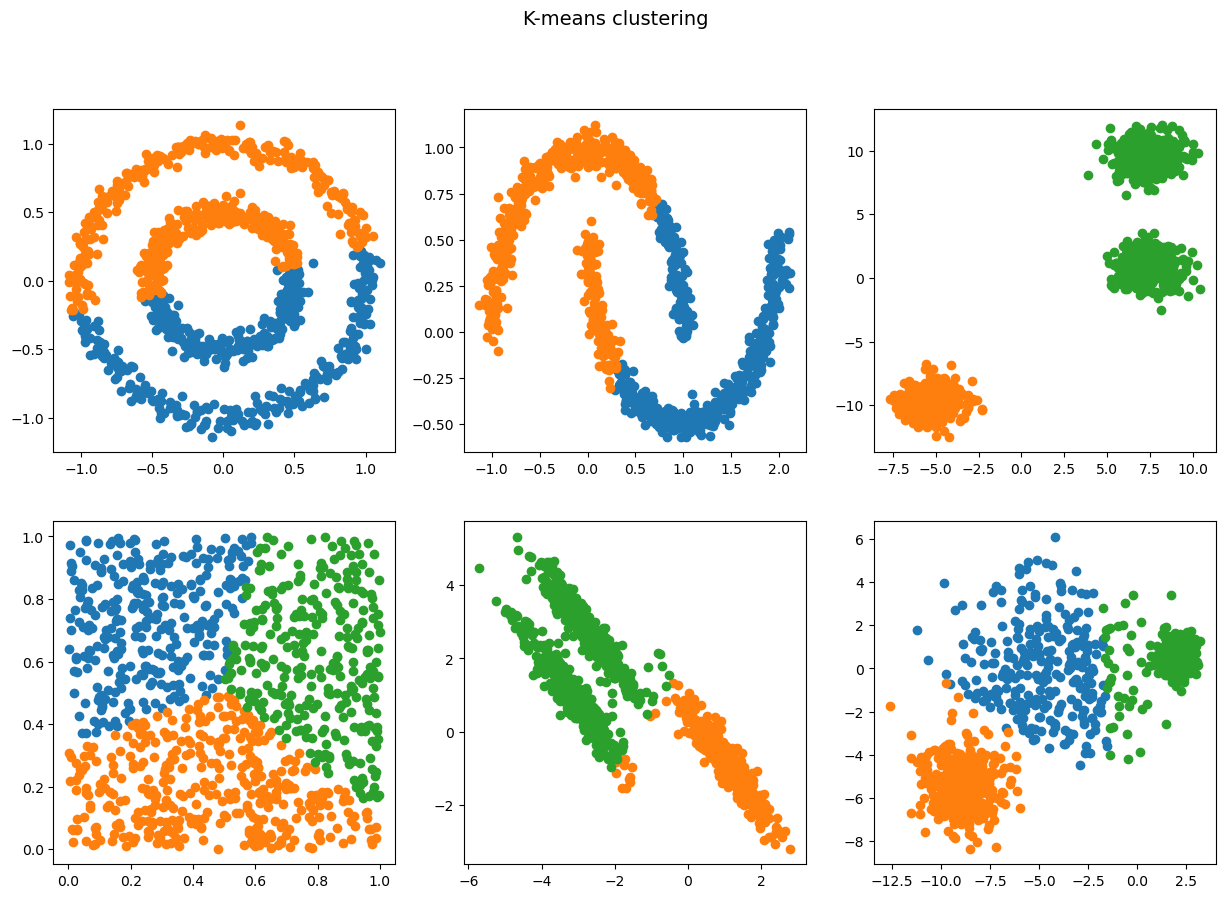

In [36]:
# Plot the datasets classified in clusters

plot_datasets_with_labels( gen_datasets, gen_datasets_pred_labels, title="K-means clustering" )

## Agglomerative clustering

#### Wrappers for the functions written in C++

In [37]:
def agglomerative_clusters_in_Cpp( data, nClusters ):
    # Arrays for the output of the computation in C++
    # This will hold the cluster index of each data point
    clusterIndices = np.zeros( (len(data)), dtype=np.int32 )
    # This will hold the position of the cluster means
    clusterMeans = np.zeros( (nClusters, len(data[0])), dtype=float )

    # Make sure that both arrays are contiguous, and that their data type is correct
    if not data.flags["C_CONTIGUOUS"]:
        data = np.ascontiguousarray( data )
    if not clusterIndices.flags["C_CONTIGUOUS"]:
        clusterIndices = np.ascontiguousarray( clusterIndices )
    if not clusterMeans.flags["C_CONTIGUOUS"]:
        clusterMeans = np.ascontiguousarray( clusterMeans )
    if not data.dtype == 'float':
        data = data.astype( 'float' )

    # Setup the types of the arguments of the function
    lib.computeAgglomerativeClusters.argtypes = [ np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ),
                                                  ctypes.c_int, ctypes.c_int, ctypes.c_int,
                                                  np.ctypeslib.ndpointer( dtype=ctypes.c_int, flags="C_CONTIGUOUS" ),
                                                  np.ctypeslib.ndpointer( dtype=ctypes.c_double, flags="C_CONTIGUOUS" ) ]

    # Setup the type of the return value of the function
    lib.computeAgglomerativeClusters.restype = None

    # Call the function
    lib.computeAgglomerativeClusters( data, len(data), len(data[0]), nClusters, clusterIndices, clusterMeans )

    return clusterIndices, clusterMeans

#### Apply it on the `test_cluster.dat` dataset

In [38]:
# Load the dataset
file = open('Datasets/test_cluster.dat')
data = []

for line in file:
    data.append( [] )
    line_aux = line.split( ' ' )
    for i in range( len(line_aux) ):
        data[-1].append( float(line_aux[i]) )
data = np.array( data )

file.close()

In [39]:
# Compute the positions and labels of the clusters
nClusters = 5
clusterIndices, clusterMeans = agglomerative_clusters_in_Cpp( data, nClusters )

Computing agglomerative clusters...
Data classified in 5 clusters, found after 995 iterations.


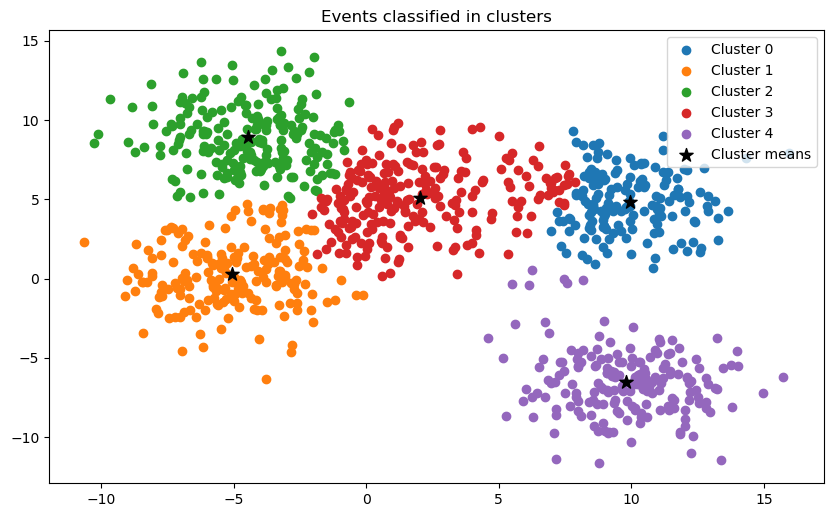

In [40]:
# Plot the data
fig1 = plt.figure()
ax1 = fig1.add_subplot(111)
ax1.set_title('Events classified in clusters')

# Plot the data with different colors for the clusters
for k in range( nClusters ):
    mask = clusterIndices == k
    ax1.scatter( data[mask, 0], data[mask, 1], label="Cluster {}".format(k))

# Plot also the centers of the clusters
ax1.scatter( clusterMeans[:, 0], clusterMeans[:, 1], c='k', s=100, marker='*', label="Cluster means" )

plt.legend(loc="best")

plt.show()

#### Apply it on several generated datasets

I follow the notebooks provided with https://arxiv.org/abs/1803.08823

In [41]:
# Array to store the cluster labels of each dataset
gen_datasets_pred_labels = np.zeros( (len(gen_datasets_true_labels), len(gen_datasets_true_labels[0])), dtype=int )

for i_dataset, dataset in enumerate(gen_datasets):
    # Compute the cluster labels
    clusterLabels, _ = agglomerative_clusters_in_Cpp( dataset[0], gen_datasets_cluster_parameters[i_dataset]["n_clusters"] )
    # Store the cluster labels
    gen_datasets_pred_labels[i_dataset] = clusterLabels


Computing agglomerative clusters...
Data classified in 2 clusters, found after 998 iterations.
Computing agglomerative clusters...
Data classified in 2 clusters, found after 998 iterations.
Computing agglomerative clusters...
Data classified in 3 clusters, found after 997 iterations.
Computing agglomerative clusters...
Data classified in 3 clusters, found after 997 iterations.
Computing agglomerative clusters...
Data classified in 3 clusters, found after 997 iterations.
Computing agglomerative clusters...
Data classified in 3 clusters, found after 997 iterations.


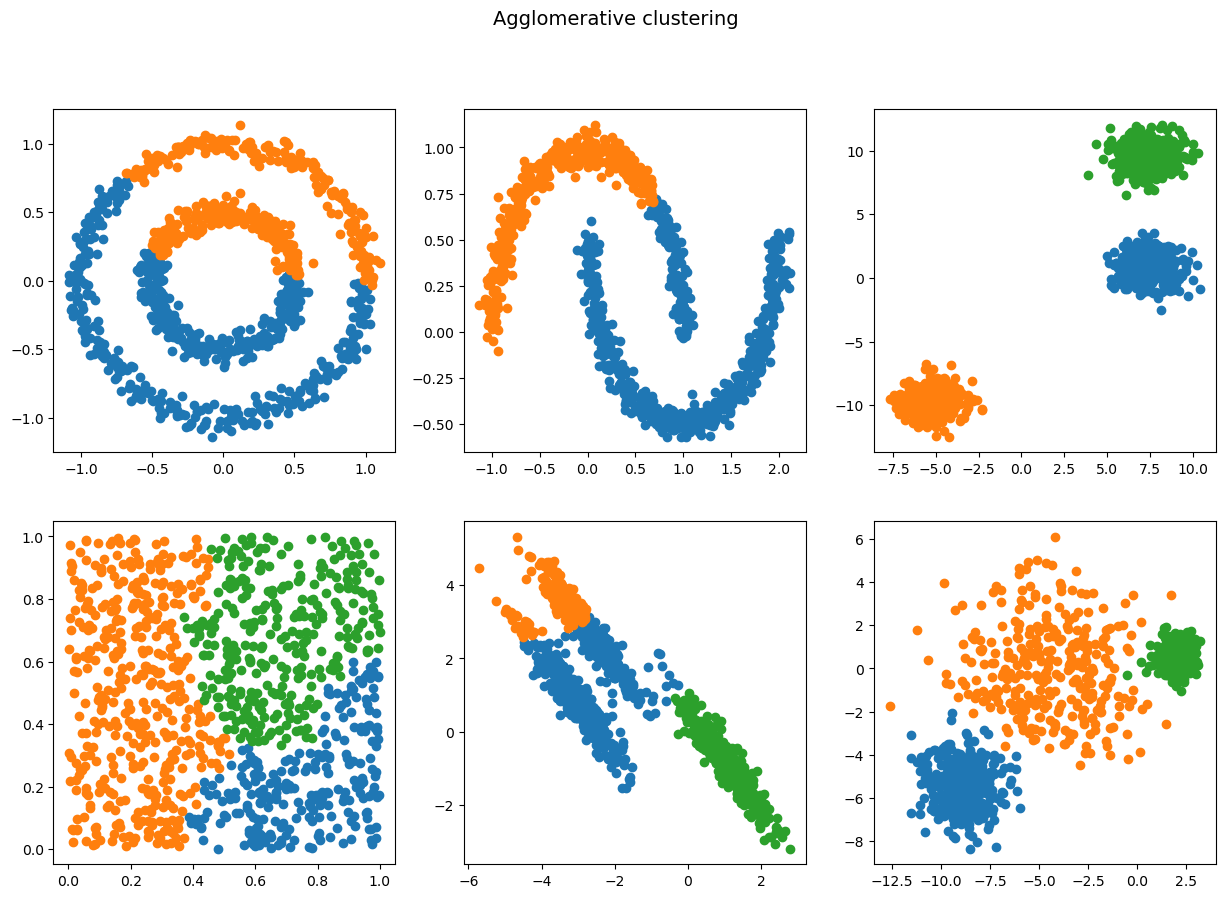

In [42]:
# Plot the datasets classified in clusters

plot_datasets_with_labels( gen_datasets, gen_datasets_pred_labels, title="Agglomerative clustering" )